In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from glob import glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 
from glob import glob
from tqdm import tqdm_notebook as tqdm
from time import time
from PIL import Image
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg
import torchvision
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import xml.etree.ElementTree as ET
import random
from torch.nn.utils import spectral_norm
from scipy.stats import truncnorm
import torch as th
#ROOT = '/kaggle/input/generative-dog-images/'
#/kaggle/input/generative-dog-images/Annotation.zip

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir("../input/generative-dog-images"))
print(os.listdir("/kaggle/input/generative-dog-images/"))
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['Annotation.zip', 'all-dogs.zip']
['Annotation.zip', 'all-dogs.zip']


**Data introduction and the Problem** 

The dataset contains the Dogs images and the problem is to extract the dataset before using it for modeling. The proccess involve Data Mining  Pipeline which include Data understanding, Data pre-processing, Data Understanding, Data werehousing, Data Modleing and Data evaluation. 

There are two networks :  Generator and a Discriminator.  The genrator a "fake" sample given a random vector and the discrimator attempts to detect whether a given sample is real or not

In [2]:
# The dataset contains zip folder and I will unzip the folder
from zipfile import ZipFile


In [3]:
file_path = '/kaggle/input/generative-dog-images/all-dogs.zip'
#file_path = '/kaggle/working/'
os.path.exists(file_path)

True

In [4]:
#All_dogs = zipfile.zipFile('/kaggle/input/generative-dog-images/all-dogs.zip', 'r')
zip_file = ZipFile(file_path, 'r')
zip_file.extractall("/kaggle/working/all-dogs")


In [5]:
zip_file = ZipFile("/kaggle/input/generative-dog-images/Annotation.zip")
zip_file.extractall("/kaggle/working/Annotation")

**Exploratory Data Analysis**

Let's load this dataset using the ImageFolder class from torchvision. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range (-1, 1), which is more convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [6]:
print(os.listdir("/kaggle/working/"))

['.virtual_documents', 'Annotation', 'all-dogs']


In [7]:
# List first 10 images
print(os.listdir(os.path.join("/kaggle/working/", 'all-dogs','all-dogs'))[:10])

['n02108915_2279.jpg', 'n02091635_1612.jpg', 'n02105505_4302.jpg', 'n02113023_7038.jpg', 'n02108915_2899.jpg', 'n02096437_1171.jpg', 'n02091467_7363.jpg', 'n02099849_1234.jpg', 'n02097474_6916.jpg', 'n02102480_7625.jpg']


In [8]:
total_images = len(os.listdir(os.path.join("/kaggle/working/", 'all-dogs','all-dogs')))
print(f"There are total {total_images} images present in the dataset.")

There are total 20579 images present in the dataset.


In [9]:
import cv2
test_img = cv2.imread(os.path.join("/kaggle/working/", 'all-dogs','all-dogs','n02085620_10074.jpg'))
test_img.shape

(500, 333, 3)

In [10]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [11]:
image_size = 128
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [12]:
total_images = len(os.listdir(os.path.join("/kaggle/working/", 'all-dogs','all-dogs')))
print(f"There are total {total_images} images present in the dataset.")

There are total 20579 images present in the dataset.


In [13]:
train_ds = ImageFolder("/kaggle/working/all-dogs/", transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

**Visualization**

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [14]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [16]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

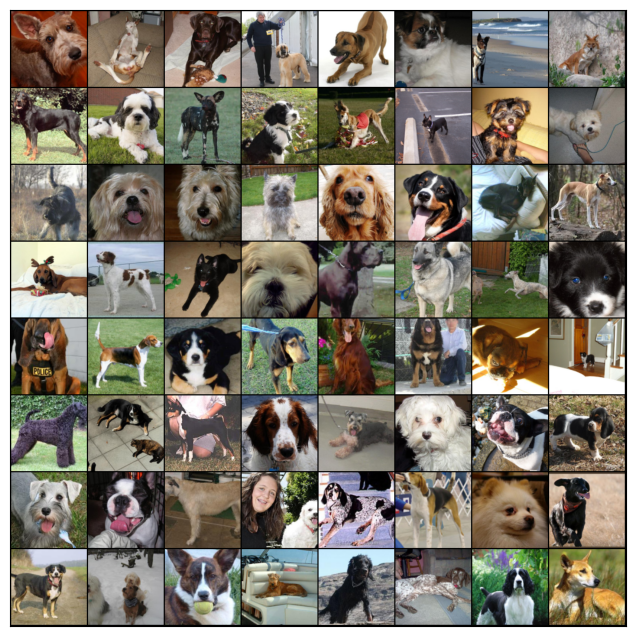

In [17]:
show_batch(train_dl)

In [18]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Model Architecture**

**Discriminator Network**

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

In [19]:
import torch.nn as nn

In [20]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 16 x 64 x 64
    
    nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 32 x 32

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 16 x 16

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 8 x 8

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 4 x 4
    
    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    # nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.BatchNorm2d(512),
    # nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 2 x 2

    # nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [21]:
# Apply the weights_init function to randomly initialize all weights
discriminator.apply(weights_init)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13

**Generator Network**

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28

In [22]:
latent_size = 128

In [23]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

torch.Size([64, 3, 128, 128])


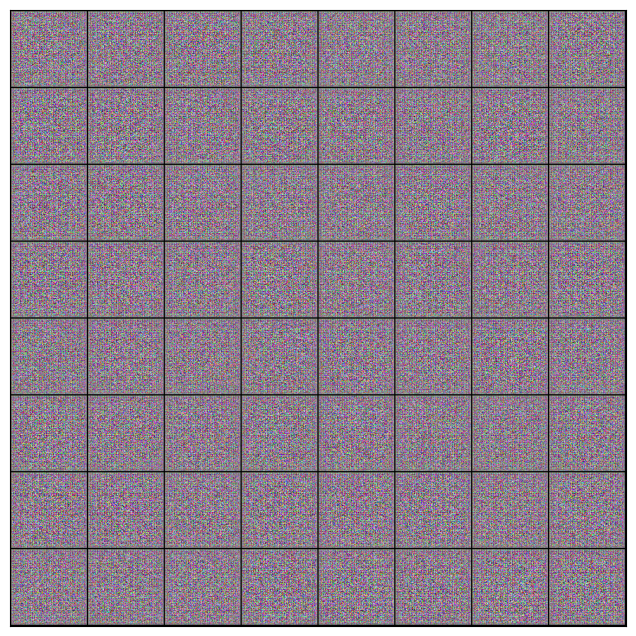

In [24]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 
from glob import glob
import os

batch_size = 32
batch_size = 32
batchSize = 64
imageSize = 64

# 64x64 images!
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [26]:
# Apply the weights_init function to randomly initialize all weights
generator.apply(weights_init)

Sequential(
  (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride

**Discriminator Training**
Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

In [27]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

**Generator Training**

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

We generate a batch of images using the generator, pass the into the discriminator.

We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [28]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [29]:
from torchvision.utils import save_image

In [30]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [31]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [32]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1)

**Result**

The output is basically random noise

Saving generated-images-0000.png


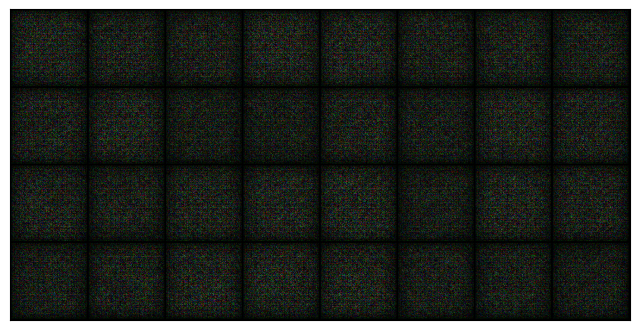

In [33]:
save_samples(0, fixed_latent)

In [34]:
 print(os.getcwd())

/kaggle/working


In [34]:
start = time()

In [35]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [36]:
class DataGenerator(Dataset):
    def __init__(self, directory, transform=None, n_samples=np.inf):
        self.directory = directory
        self.transform = transform
        self.n_samples = n_samples

        self.samples = self._load_subfolders_images(directory)
        if len(self.samples) == 0:
            raise RuntimeError("Found 0 files in subfolders of: {}".format(directory))

    def _load_subfolders_images(self, root):
        IMG_EXTENSIONS = (
        '.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

        def is_valid_file(x):
            return torchvision.datasets.folder.has_file_allowed_extension(x, IMG_EXTENSIONS)

        required_transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize(64),
                torchvision.transforms.CenterCrop(64),
        ])

        imgs = []
        paths = []
        for root, _, fnames in sorted(os.walk(root)):
            for fname in sorted(fnames)[:min(self.n_samples, 999999999999999)]:
                path = os.path.join(root, fname)
                paths.append(path)

        for path in paths:
            if is_valid_file(path):
                # Load image
                img = dset.folder.default_loader(path)

                # Get bounding boxes
                annotation_basename = os.path.splitext(os.path.basename(path))[0]
                annotation_dirname = next(
                        dirname for dirname in os.listdir('../working/Annotation/Annotation/') if
                        dirname.startswith(annotation_basename.split('_')[0]))
                annotation_filename = os.path.join('../working/Annotation/Annotation/',
                                                   annotation_dirname, annotation_basename)
                tree = ET.parse(annotation_filename)
                root = tree.getroot()
                objects = root.findall('object')
                for o in objects:
                    bndbox = o.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    
                    w = np.min((xmax - xmin, ymax - ymin))
                    bbox = (xmin, ymin, xmin+w, ymin+w)
                    object_img = required_transforms(img.crop(bbox))
                    #object_img = object_img.resize((64,64), Image.ANTIALIAS)
                    imgs.append(object_img)
        return imgs

    def __getitem__(self, index):
        sample = self.samples[index]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return np.asarray(sample)
    
    def __len__(self):
        return len(self.samples)

In [37]:
%%time
database = '../working/all-dogs/all-dogs/'

transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DataGenerator(database, transform=transform,n_samples=25000)


train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,batch_size=batch_size, num_workers = 4)

CPU times: user 46.7 s, sys: 2.79 s, total: 49.5 s
Wall time: 49.5 s


In [38]:
class PixelwiseNorm(nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y

In [39]:
def show_generated_img_all():
    gen_z = torch.randn(32, nz, 1, 1, device=device)
    gen_images = netG(gen_z).to("cpu").clone().detach()
    gen_images = gen_images.numpy().transpose(0, 2, 3, 1)
    gen_images = (gen_images+1.0)/2.0
    fig = plt.figure(figsize=(25, 16))
    for ii, img in enumerate(gen_images):
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
        plt.imshow(img)

In [40]:
### This is to show one sample image for iteration of chosing
def show_generated_img():
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    gen_image = ((gen_image+1.0)/2.0)
    plt.imshow(gen_image)
    plt.show()

In [41]:
#Minibatch standard deviation layer for the discriminator
class MinibatchStdDev(th.nn.Module):
    

    def __init__(self):
        
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
       
        batch_size, _, height, width = x.shape
        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)
        # [1 x C x H x W]  Calc standard deviation over batch
        y = th.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size,1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = th.cat([x, y], 1)
        # return the computed values:
        return y

/tmp/ipykernel_34/442157279.py:121: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ii, (real_images) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/692 [00:00<?, ?it/s]

[1/40][0/692] Loss_D: 1.4437 Loss_G: 3.3125 D(x): 0.4733 D(G(z)): 0.5031 / 0.0090
[1/40][500/692] Loss_D: 0.9505 Loss_G: 3.2158 D(x): 0.6669 D(G(z)): 0.2168 / 0.0105


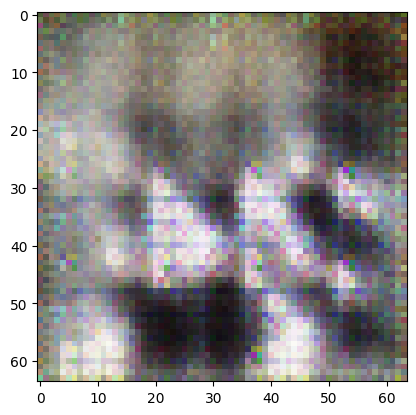

  0%|          | 0/692 [00:00<?, ?it/s]

[2/40][308/692] Loss_D: 0.9530 Loss_G: 1.6570 D(x): 0.4376 D(G(z)): 0.1378 / 0.1152


  0%|          | 0/692 [00:00<?, ?it/s]

[3/40][116/692] Loss_D: 1.0739 Loss_G: 1.7119 D(x): 0.5415 D(G(z)): 0.2843 / 0.0998
[3/40][616/692] Loss_D: 1.0772 Loss_G: 1.5221 D(x): 0.4056 D(G(z)): 0.2100 / 0.1289


  0%|          | 0/692 [00:00<?, ?it/s]

[4/40][424/692] Loss_D: 1.0367 Loss_G: 2.0475 D(x): 0.3251 D(G(z)): 0.0861 / 0.0686


  0%|          | 0/692 [00:00<?, ?it/s]

[5/40][232/692] Loss_D: 1.2122 Loss_G: 2.3173 D(x): 0.6972 D(G(z)): 0.4238 / 0.0429


  0%|          | 0/692 [00:00<?, ?it/s]

[6/40][40/692] Loss_D: 0.9145 Loss_G: 1.4516 D(x): 0.5895 D(G(z)): 0.2351 / 0.1449
[6/40][540/692] Loss_D: 0.9911 Loss_G: 1.2829 D(x): 0.4311 D(G(z)): 0.1566 / 0.1863


  0%|          | 0/692 [00:00<?, ?it/s]

[7/40][348/692] Loss_D: 1.0187 Loss_G: 1.2645 D(x): 0.3979 D(G(z)): 0.1258 / 0.1920


  0%|          | 0/692 [00:00<?, ?it/s]

[8/40][156/692] Loss_D: 0.9241 Loss_G: 1.6869 D(x): 0.5806 D(G(z)): 0.1899 / 0.1035
[8/40][656/692] Loss_D: 0.9509 Loss_G: 1.5917 D(x): 0.6410 D(G(z)): 0.2572 / 0.1154


  0%|          | 0/692 [00:00<?, ?it/s]

[9/40][464/692] Loss_D: 1.0245 Loss_G: 1.5855 D(x): 0.5144 D(G(z)): 0.2335 / 0.1224


  0%|          | 0/692 [00:00<?, ?it/s]

[10/40][272/692] Loss_D: 0.9564 Loss_G: 1.5467 D(x): 0.3953 D(G(z)): 0.1393 / 0.1257


  0%|          | 0/692 [00:00<?, ?it/s]

[11/40][80/692] Loss_D: 1.0201 Loss_G: 1.2884 D(x): 0.5368 D(G(z)): 0.2782 / 0.1820
[11/40][580/692] Loss_D: 1.0245 Loss_G: 1.2939 D(x): 0.4026 D(G(z)): 0.1947 / 0.1861


  0%|          | 0/692 [00:00<?, ?it/s]

[12/40][388/692] Loss_D: 1.0385 Loss_G: 1.3786 D(x): 0.3728 D(G(z)): 0.1378 / 0.1620


  0%|          | 0/692 [00:00<?, ?it/s]

[13/40][196/692] Loss_D: 0.9607 Loss_G: 1.5376 D(x): 0.3877 D(G(z)): 0.1137 / 0.1275


  0%|          | 0/692 [00:00<?, ?it/s]

[14/40][4/692] Loss_D: 1.0174 Loss_G: 1.3222 D(x): 0.4976 D(G(z)): 0.2313 / 0.1702
[14/40][504/692] Loss_D: 1.0297 Loss_G: 1.2304 D(x): 0.5638 D(G(z)): 0.2910 / 0.2014


  0%|          | 0/692 [00:00<?, ?it/s]

[15/40][312/692] Loss_D: 1.1091 Loss_G: 1.0584 D(x): 0.4991 D(G(z)): 0.2900 / 0.2642


  0%|          | 0/692 [00:00<?, ?it/s]

[16/40][120/692] Loss_D: 0.9419 Loss_G: 1.1801 D(x): 0.5135 D(G(z)): 0.2004 / 0.2148
[16/40][620/692] Loss_D: 0.9938 Loss_G: 1.3758 D(x): 0.4325 D(G(z)): 0.1834 / 0.1689


  0%|          | 0/692 [00:00<?, ?it/s]

[17/40][428/692] Loss_D: 1.0723 Loss_G: 1.5971 D(x): 0.6010 D(G(z)): 0.3228 / 0.1137


  0%|          | 0/692 [00:00<?, ?it/s]

[18/40][236/692] Loss_D: 0.9365 Loss_G: 1.4073 D(x): 0.4919 D(G(z)): 0.1818 / 0.1586


  0%|          | 0/692 [00:00<?, ?it/s]

[19/40][44/692] Loss_D: 1.1651 Loss_G: 1.2722 D(x): 0.5331 D(G(z)): 0.3614 / 0.1859
[19/40][544/692] Loss_D: 1.0548 Loss_G: 1.5134 D(x): 0.4565 D(G(z)): 0.2514 / 0.1345


  0%|          | 0/692 [00:00<?, ?it/s]

[20/40][352/692] Loss_D: 1.0951 Loss_G: 1.6388 D(x): 0.6793 D(G(z)): 0.3345 / 0.1094


  0%|          | 0/692 [00:00<?, ?it/s]

[21/40][160/692] Loss_D: 1.1365 Loss_G: 1.0184 D(x): 0.3388 D(G(z)): 0.1652 / 0.2871
[21/40][660/692] Loss_D: 1.1207 Loss_G: 1.1755 D(x): 0.5085 D(G(z)): 0.3008 / 0.2205


  0%|          | 0/692 [00:00<?, ?it/s]

[25/40][392/692] Loss_D: 0.9648 Loss_G: 1.1010 D(x): 0.4593 D(G(z)): 0.1810 / 0.2497


  0%|          | 0/692 [00:00<?, ?it/s]

[26/40][200/692] Loss_D: 0.9642 Loss_G: 1.5387 D(x): 0.5867 D(G(z)): 0.2337 / 0.1291


  0%|          | 0/692 [00:00<?, ?it/s]

[27/40][8/692] Loss_D: 0.9507 Loss_G: 1.5774 D(x): 0.6119 D(G(z)): 0.2578 / 0.1225
[27/40][508/692] Loss_D: 1.1952 Loss_G: 1.9640 D(x): 0.6886 D(G(z)): 0.3814 / 0.0716


  0%|          | 0/692 [00:00<?, ?it/s]

[28/40][316/692] Loss_D: 0.9367 Loss_G: 1.4686 D(x): 0.5921 D(G(z)): 0.2392 / 0.1420


  0%|          | 0/692 [00:00<?, ?it/s]

[29/40][124/692] Loss_D: 1.0408 Loss_G: 1.5641 D(x): 0.3297 D(G(z)): 0.1211 / 0.1239
[29/40][624/692] Loss_D: 0.9681 Loss_G: 1.6638 D(x): 0.5374 D(G(z)): 0.2191 / 0.1065


  0%|          | 0/692 [00:00<?, ?it/s]

[30/40][432/692] Loss_D: 0.9441 Loss_G: 1.2223 D(x): 0.4973 D(G(z)): 0.1950 / 0.2048


  0%|          | 0/692 [00:00<?, ?it/s]

[31/40][240/692] Loss_D: 0.9657 Loss_G: 1.3171 D(x): 0.4495 D(G(z)): 0.1614 / 0.1805


  0%|          | 0/692 [00:00<?, ?it/s]

[32/40][48/692] Loss_D: 0.9758 Loss_G: 1.4221 D(x): 0.4917 D(G(z)): 0.2138 / 0.1517
[32/40][548/692] Loss_D: 1.0245 Loss_G: 1.3425 D(x): 0.3507 D(G(z)): 0.1284 / 0.1789


  0%|          | 0/692 [00:00<?, ?it/s]

[33/40][356/692] Loss_D: 1.0198 Loss_G: 0.9804 D(x): 0.3958 D(G(z)): 0.1290 / 0.3044


  0%|          | 0/692 [00:00<?, ?it/s]

[34/40][164/692] Loss_D: 0.9971 Loss_G: 1.7331 D(x): 0.6273 D(G(z)): 0.2481 / 0.0988
[34/40][664/692] Loss_D: 0.9229 Loss_G: 1.3447 D(x): 0.6618 D(G(z)): 0.2922 / 0.1710


  0%|          | 0/692 [00:00<?, ?it/s]

[35/40][472/692] Loss_D: 1.0285 Loss_G: 1.4983 D(x): 0.6783 D(G(z)): 0.3344 / 0.1388


  0%|          | 0/692 [00:00<?, ?it/s]

[36/40][280/692] Loss_D: 0.9248 Loss_G: 1.7828 D(x): 0.4241 D(G(z)): 0.1312 / 0.0932


  0%|          | 0/692 [00:00<?, ?it/s]

[37/40][88/692] Loss_D: 0.9726 Loss_G: 1.9432 D(x): 0.5810 D(G(z)): 0.2414 / 0.0720
[37/40][588/692] Loss_D: 1.0005 Loss_G: 1.3122 D(x): 0.4369 D(G(z)): 0.1898 / 0.1811


  0%|          | 0/692 [00:00<?, ?it/s]

[38/40][396/692] Loss_D: 0.9203 Loss_G: 1.4040 D(x): 0.4914 D(G(z)): 0.1627 / 0.1538


  0%|          | 0/692 [00:00<?, ?it/s]

[39/40][204/692] Loss_D: 0.9251 Loss_G: 1.7775 D(x): 0.4597 D(G(z)): 0.1633 / 0.0909


  0%|          | 0/692 [00:00<?, ?it/s]

[40/40][12/692] Loss_D: 0.9642 Loss_G: 1.3551 D(x): 0.5873 D(G(z)): 0.2437 / 0.1744
[40/40][512/692] Loss_D: 0.9426 Loss_G: 1.5610 D(x): 0.5140 D(G(z)): 0.1787 / 0.1261


'/kaggle/working/images.zip'

In [51]:
class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()

        # input is Z, going into a convolution
        self.conv1 = spectral_norm(nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False))
        #self.bn1 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4
        
        self.conv2 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False))
        #self.bn2 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 8 x 8
        
        self.conv3 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False))
        #self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 16 x 16
        
        self.conv4 = spectral_norm(nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False))
        #self.bn4 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats * 2) x 32 x 32
        
        self.conv5 = spectral_norm(nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False))
        #self.bn5 = nn.BatchNorm2d(nfeats)
        # state size. (nfeats) x 64 x 64
        
        self.conv6 = spectral_norm(nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False))
        # state size. (nchannels) x 64 x 64
        self.pixnorm = PixelwiseNorm()
    def forward(self, x):
        #x = F.leaky_relu(self.bn1(self.conv1(x)))
        #x = F.leaky_relu(self.bn2(self.conv2(x)))
        #x = F.leaky_relu(self.bn3(self.conv3(x)))
        #x = F.leaky_relu(self.bn4(self.conv4(x)))
        #x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv4(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv5(x))
        x = self.pixnorm(x)
        x = torch.tanh(self.conv6(x))
        
        return x



class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()

        # input is (nchannels) x 64 x 64
        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        # state size. (nfeats) x 32 x 32
        
        self.conv2 = spectral_norm(nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False))
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats*2) x 16 x 16
        
        self.conv3 = spectral_norm(nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False))
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 8 x 8
       
        self.conv4 = spectral_norm(nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False))
        self.bn4 = nn.MaxPool2d(2)
        # state size. (nfeats*8) x 4 x 4
        self.batch_discriminator = MinibatchStdDev()
        self.pixnorm = PixelwiseNorm()
        self.conv5 = spectral_norm(nn.Conv2d(nfeats * 8 +1, 1, 2, 1, 0, bias=False))
        # state size. 1 x 1 x 1
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
       # x = self.pixnorm(x)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
       # x = self.pixnorm(x)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
       # x = self.pixnorm(x)
        x = self.batch_discriminator(x)
        x = torch.sigmoid(self.conv5(x))
        #x= self.conv5(x)
        return x.view(-1, 1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.0002
lr_d = 0.0002
beta1 = 0.5
epochs = 40
netG = Generator(100, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

criterion = nn.BCELoss()
#criterion = nn.MSELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_d, betas=(beta1, 0.999))
lr_schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG,
                                                                     T_0=epochs//20, eta_min=0.00005)
lr_schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD,
                                                                     T_0=epochs//20, eta_min=0.00005)

nz = 100
fixed_noise = torch.randn(25, nz, 1, 1, device=device)

real_label = 0.7
fake_label = 0.0
batch_size = train_loader.batch_size



### training here


step = 0
for epoch in range(epochs):
    for ii, (real_images) in tqdm(enumerate(train_loader), total=len(train_loader)):
        end = time()
        if (end -start) > 25000 :
            break
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device) +  np.random.uniform(-0.1, 0.1)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label) + np.random.uniform(0, 0.2)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if step % 500 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
            valid_image = netG(fixed_noise)
        step += 1
        lr_schedulerG.step(epoch)
        lr_schedulerD.step(epoch)

    if epoch % 200 == 0:
        show_generated_img()
        
# torch.save(netG.state_dict(), 'generator.pth')
# torch.save(netD.state_dict(), 'discriminator.pth')

def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 100
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    z = truncated_normal((im_batch_size, 100, 1, 1), threshold=1)
    gen_z = torch.from_numpy(z).float().to(device)    
    #gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image((gen_images[i_image, :, :, :] +1.0)/2.0, os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

**Results from the models**

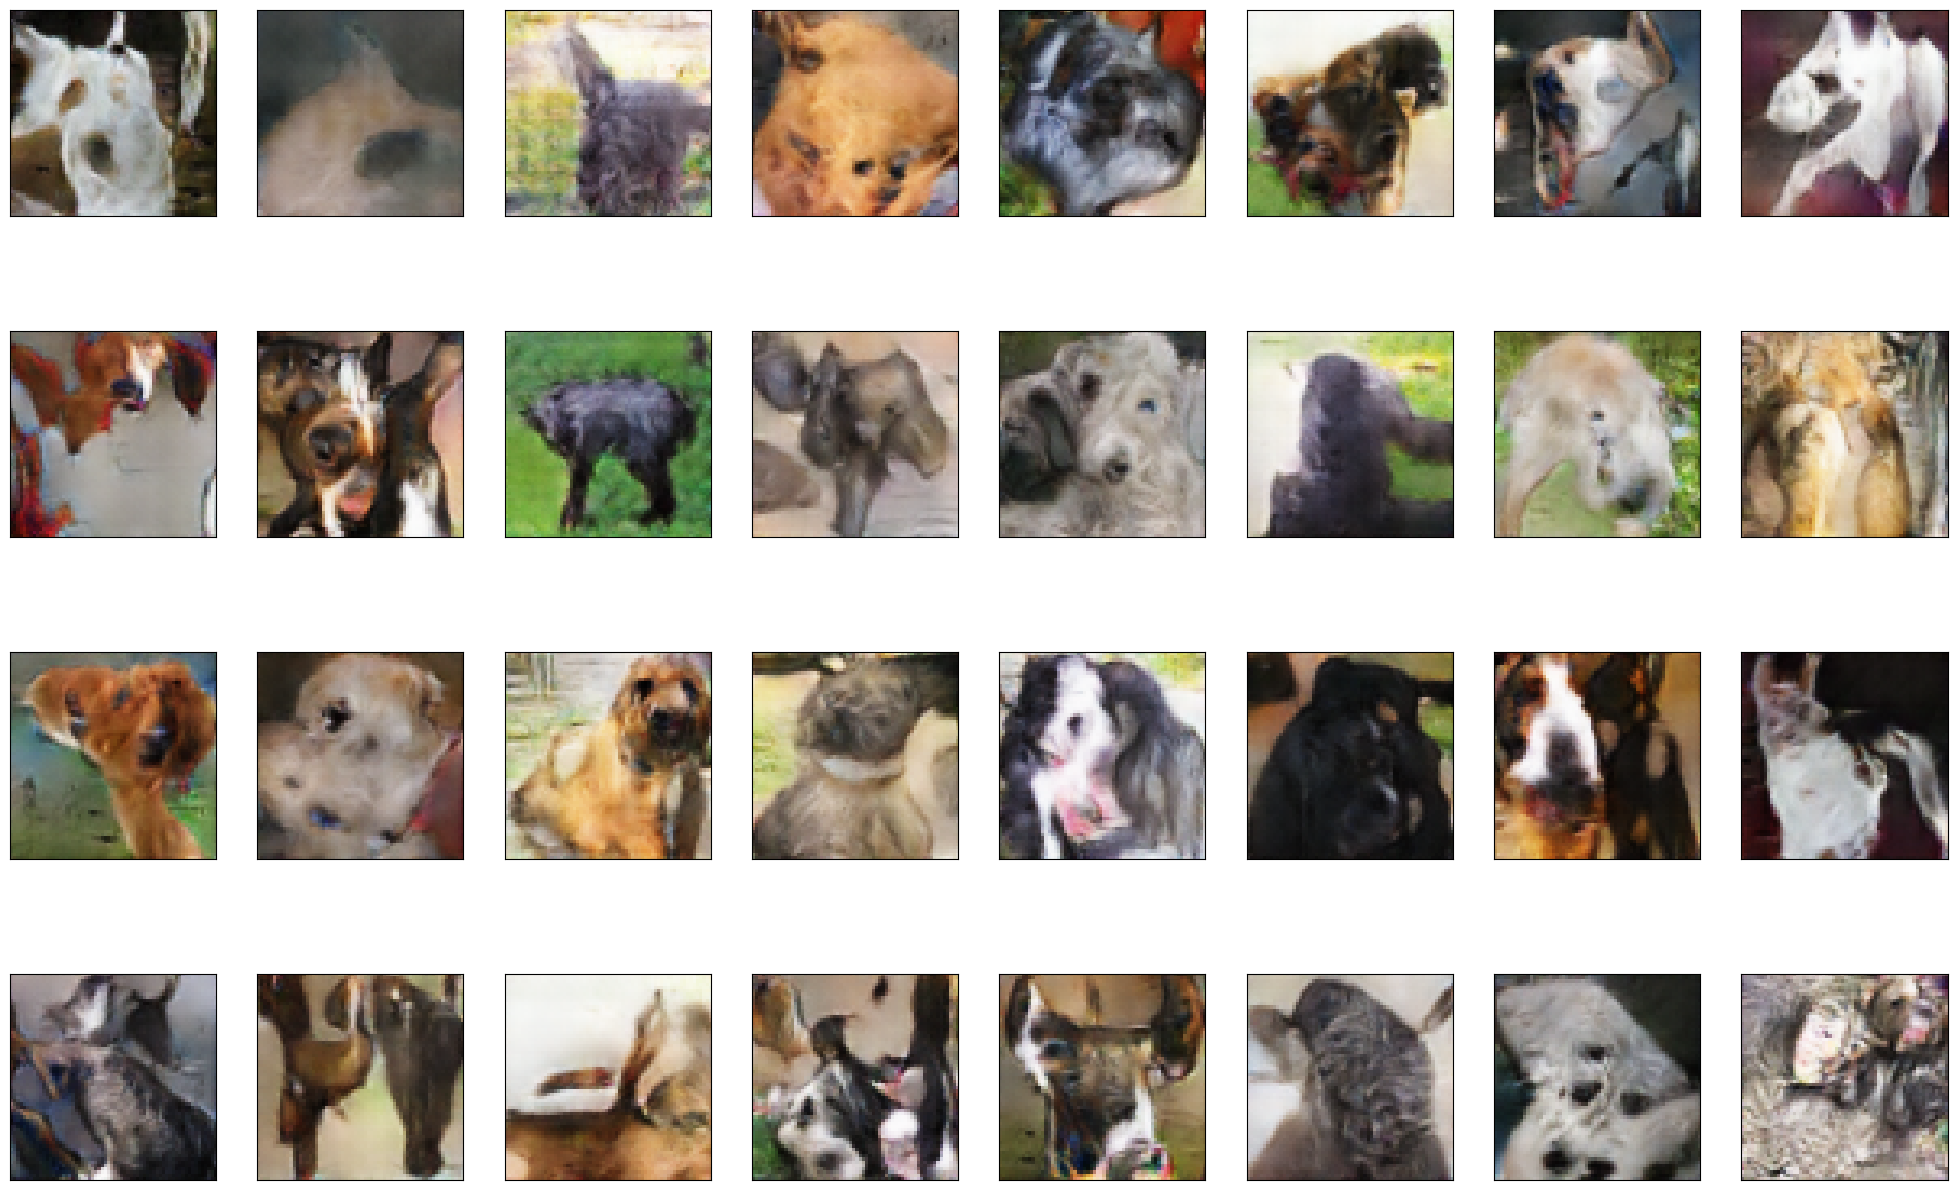

In [52]:
show_generated_img_all()

**Conclusion** 

The model trains a GAN (Generative Adersarial Networks) to generate fake images of dogs. Using Data Mining Pipeline procedure and identified if the dogs are real of fake based on generative model and also visualized the output. 